## Read in data, preprocess (involving filtration, cleaning), produce turning point labels, carry out feature selection using fwd returns

In [10]:
import findspark # set up the Spark environment in Python. It helps locate the Spark installation and adds it to the system path
findspark.init() # Initializes the Spark environment so that you can use PySpark in your Python script.

from pyspark import SparkConf # This module is used to configure Spark properties
from pyspark.sql import SparkSession, functions as F # SparkSession allows you to create df, register df as tables, execute SQL over tables, etc.
from pyspark.sql.window import Window # Used to define window specifications for window functions
from pyspark.sql.functions import when, lit, lag, last, col, lead, countDistinct, udf, pandas_udf, PandasUDFType, coalesce, \
                                month, year, concat, date_format, format_string, last_day, months_between, greatest, least, abs, \
                                dayofweek, isnan, count # these functions are used for different DataFrame operations
from pyspark.sql.types import *
from pyspark import SparkContext

from pyspark.sql import SparkSession
# # from joblibspark import register_spark

sc = SparkContext.getOrCreate() # creates or retrieves an existing SparkContext instance.
sc.addPyFile('utils.py') # ensuring that file is distributed to each worker node in the cluster

# for shared metastore (shared across all users)
#spark = SparkSession.builder.appName("Fundamental_features2024").getOrCreate()
#spark.sql("USE 2024_06_18");

### Class of Utilities

In [11]:
from pyspark.ml.regression import RandomForestRegressor
from sklearn import preprocessing
from pyspark.ml.feature import VectorAssembler, VarianceThresholdSelector, StandardScaler, StringIndexer
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from scipy.stats import zscore

import findspark
from pyspark.sql.functions import sum, when, lit, lag, last, col, lead, countDistinct, udf, pandas_udf, PandasUDFType, coalesce, month, year, concat, date_format, format_string, last_day, months_between, greatest, least, abs, dayofweek, isnan, count, to_date, struct
# lit creates a column with a literal value.
# lag/lead window functions access a value in a column from a previous or next row.
# last and col used for selecting the last value in a window and referencing columns
# coalesce, greatest, least, abs: Various functions for handling null values, selecting maximum/minimum values, and calculating absolute values.
# month, year, dayofweek: Functions to extract parts of a date.
# concat, date_format, format_string: Functions for string operations.
# last_day, months_between: Functions for date calculations.
from pyspark.sql.types import *
from pyspark.sql.window import Window # Imports the Window class, used to define window specifications for window functions.
from pyspark.sql import SparkSession, functions as F # Imports SparkSession (entry point for Spark SQL) and functions (shorthand alias for PySpark SQL functions).
from pyspark.ml.linalg import Vectors, VectorUDT

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import csv
from functools import reduce # Imports the reduce function, used for applying a function cumulatively to items of a sequence.
from datetime import datetime
import os # interacting with operating system

class Utils():
    
    def __init__(self, sector):
        self.sector = sector

        findspark.init()
        self.spark = SparkSession.builder.appName("MomentumRankings_2024").getOrCreate()
        self.spark.sql("USE 2024_06_18");
    
    def get_price_data(self, extract_dates=False, raw=False):
        """Select all price data for the sector """
        
        query = """SELECT DISTINCT s.fsym_id AS fsym_id, sm.factset_sector_desc, sc.proper_name, p.p_date, p.p_price,
                    divs.p_divs_exdate, divs.p_divs_s_pd, divs.p_divs_pd, splits.p_split_date, splits.p_split_factor

                    FROM sym_entity_sector AS e

                    INNER JOIN fp_sec_entity AS s ON e.factset_entity_id = s.factset_entity_id
                    INNER JOIN sym_coverage AS sc ON s.fsym_id = sc.fsym_security_id 
                    INNER JOIN fp_basic_prices AS p ON sc.fsym_regional_id = p.fsym_id
                    INNER JOIN FF_BASIC_CF AS mv ON mv.fsym_id = p.fsym_id
                    INNER JOIN factset_sector_map AS sm ON e.sector_code = sm.factset_sector_code
                    INNER JOIN ff_basic_qf AS ff ON p.fsym_id = ff.fsym_id
                    LEFT JOIN fp_basic_dividends AS divs ON divs.p_divs_exdate = p.p_date AND p.fsym_id = divs.fsym_id
                    LEFT JOIN fp_basic_splits AS splits ON splits.p_split_date = p.p_date AND p.fsym_id = splits.fsym_id 

                    WHERE sc.fsym_security_id IS NOT NULL
                    AND (sm.factset_sector_desc != 'Miscellaneous' AND sm.factset_sector_desc != 'Government') 
                    AND sc.fref_security_type IS NOT NULL AND sc.fref_security_type = 'SHARE'
                    AND sc.currency IS NOT NULL AND sc.currency = 'USD'
                    AND s.factset_entity_id IS NOT NULL
                    AND e.sector_code IS NOT NULL
                    AND p.p_date IS NOT NULL
                    AND (sc.fref_listing_exchange = 'NAS' OR sc.fref_listing_exchange = 'NYS')
                    AND p.p_date >= '2000-01-01'
                    AND sm.factset_sector_desc = '{0}'
                    AND mv.ff_mkt_val > 500

                    ORDER BY fsym_id ASC, p_date DESC""".format(self.sector)
        # Retrieves distinct price data and related fields for securities in the specified sector.
        adj = self.spark.sql(query)
        
        if raw:
            return adj
        else:
            if extract_dates:
                min_max_dates = self.func_min_max_dates(adj, which=2) # extracts the minimum and maximum dates

            # Calculate Cum Split Factor, withColumn adds or modifies columns in the DataFrame for split factors.
            adj = adj.withColumn("temp_split_factor", when(adj.p_date==adj.p_split_date, lit(adj.p_split_factor)).otherwise(lit(1.0)))
            adj = adj.withColumn("div_split_factor", lit(0.0)) # placeholders
            adj = adj.withColumn("cum_split_factor", lit(0.0)) # placeholders
            adj = adj.withColumn("split_temp_i", lit(0)) # placeholders - for ordering purposes

            # creating udf to calculate cumulative split factor
            result_schema = adj.schema
            adj = adj.groupBy('fsym_id').applyInPandas(self.calc_product_factor, schema=result_schema)

            #Split adjusted Price/Dividends
            adj = adj.withColumn("split_adj_price", (adj.p_price*adj.cum_split_factor))
            adj = adj.withColumn("split_adj_div", (adj.p_divs_pd*adj.cum_split_factor))

            # prepares columns necessary for spinoff factor calculation
            adj = adj.withColumn("div_factor", when(((adj.p_date == adj.p_divs_exdate) & (adj.p_divs_s_pd == 1)), lit(adj.p_divs_pd*adj.cum_split_factor)).otherwise(lit(0.0)))
            adj = adj.withColumn("temp_cum_spin_factor", when((adj.split_adj_price - adj.div_factor <= 0), lit(1.0)) \
                                 .otherwise(lit((adj.split_adj_price - adj.div_factor)/adj.split_adj_price)))
            adj = adj.withColumn("cum_spin_factor", lit(0.0))
            adj = adj.withColumn("spin_temp_i", lit(0)) # placeholders - for ordering purposes
            
            result_schema = adj.schema
            adj = adj.groupBy('fsym_id').applyInPandas(self.calc_product_spinoff, schema=result_schema) 

            # Fully Adjusted Price
            adj = adj.withColumn("adj_price", adj.split_adj_price * adj.cum_spin_factor)
            
            if extract_dates:
                return adj, min_max_dates
            else:
                return adj
        
        # retrieves fundamental data for the specified sector.
    def get_fundamental_data(self, extract_dates=False):
        """ Select all fundamental data"""
        
        fun_columns = self.spark.sql("SELECT * FROM ff_basic_qf LIMIT 1").columns
        
        funder_columns = self.spark.sql("SELECT * FROM ff_basic_der_qf LIMIT 1").columns
        funder_columns = [col for col in funder_columns if col not in fun_columns]
        funder_columns_str = ', '.join([f'funder.{col}' for col in funder_columns])
        
        fun_adv_columns = self.spark.sql("SELECT * FROM ff_advanced_qf LIMIT 1").columns
        fun_adv_columns = [col for col in fun_adv_columns if col not in fun_columns and col not in funder_columns]
        fun_adv_columns_str = ', '.join([f'fun_adv.{col}' for col in fun_adv_columns])
        
        funder2_columns = self.spark.sql("SELECT * FROM ff_advanced_der_qf LIMIT 1").columns
        funder2_columns = [col for col in funder2_columns if col not in fun_columns and col not in funder_columns and col not in fun_adv_columns]
        funder2_columns_str = ', '.join([f'funder2.{col}' for col in funder2_columns])
  
        # AND sec.factset_sector_desc = '{0}' ???
        query = f"""SELECT DISTINCT sc.fsym_id AS fsym, e.factset_entity_id, sec.factset_sector_desc, 
                    fun.*, {funder2_columns_str}, {fun_adv_columns_str}, {funder_columns_str}

                FROM sym_entity_sector AS e

                INNER JOIN ff_sec_entity AS sc ON e.factset_entity_id = sc.factset_entity_id
                INNER JOIN sym_coverage AS sm ON sc.fsym_id = sm.fsym_security_id 
                INNER JOIN factset_sector_map AS sec ON e.sector_code = sec.factset_sector_code
                INNER JOIN ff_basic_qf AS fun ON sm.fsym_regional_id = fun.fsym_id
                INNER JOIN FF_BASIC_CF AS mv ON sm.fsym_regional_id = mv.fsym_id
                INNER JOIN ff_basic_der_qf AS funder ON sm.fsym_regional_id = funder.fsym_id and funder.date = fun.date
                INNER JOIN ff_advanced_der_qf AS funder2 ON sm.fsym_regional_id = funder2.fsym_id and funder2.date = fun.date
                INNER JOIN ff_advanced_qf AS fun_adv ON sm.fsym_regional_id = fun_adv.fsym_id and fun_adv.date = fun.date

                WHERE sm.fsym_id IS NOT NULL
                AND (sec.factset_sector_desc != 'Miscellaneous' AND sec.factset_sector_desc != 'Government') 
                AND sm.fref_security_type IS NOT NULL AND sm.fref_security_type = 'SHARE'
                AND sm.currency IS NOT NULL AND sm.currency = 'USD'
                AND e.factset_entity_id IS NOT NULL
                AND e.sector_code IS NOT NULL
                AND (sm.fref_listing_exchange = 'NAS' OR sm.fref_listing_exchange = 'NYS')
                AND funder.date >= '2000-01-01'
                AND mv.ff_mkt_val > 500

                ORDER BY fsym ASC, date DESC""".format(self.sector)
        
        fundamentals = self.spark.sql(query)
        if extract_dates:
            min_max_dates = self.func_min_max_dates(fundamentals, which=1)
            return fundamentals, min_max_dates
        else:
            return fundamentals

    
    def align_data(self, fundamental_dates, price_dates, fundamental_df, price_df):
        """Remove companies where the price and fundamental data is not aligned (one prior to other)"""
        
        # Removing data that doesnt align between prices and fundamentals
        min_max_dates = fundamental_dates.join(price_dates.withColumnRenamed('fsym_id', 'fsym'), ['fsym'], 'inner')
        # Joins fundamental_dates and price_dates on the fsym (financial symbol) column, aligning companies by their financial symbol.
        # The price_dates DataFrame's fsym_id column is renamed to fsym for the join.
        
        # getting maximum of minimum dates and minimum of maximum dates - max of min dates is most important
        min_max_dates = min_max_dates.withColumn('abs_min', when(col('min_fun') > col('min_adj'), lit(col('min_fun'))).otherwise(lit(col('min_adj'))))
        # Takes the later of the minimum dates between fundamental and price data (max(min_fun, min_adj)).
        min_max_dates = min_max_dates.withColumn('abs_max', lit(col('max_adj'))) # always want max date to be price history

        # if abs_max is less than abs_min get rid of entry (price history and reporting history don't match up)
        min_max_dates = min_max_dates.withColumn('keep', when(col('abs_max')<col('abs_min'), lit(0)).otherwise(lit(1)))
        # Adds a column that flags entries where the abs_max date is before the abs_min date (misaligned data) as 0, otherwise 1.
        min_max_dates = min_max_dates.where(col('keep')==1)
        # Filters out rows where keep is 0.
        min_max_dates = min_max_dates.drop('keep', 'min_fun', 'max_fun', 'min_adj', 'max_adj')
        # Drops unnecessary columns used for calculations

        new_fundamental_df = fundamental_df.join(min_max_dates.select('fsym'), ['fsym'], 'inner')
        new_price_df = price_df.join(min_max_dates.select('fsym').withColumnRenamed('fsym', 'fsym_id'), ['fsym_id'], 'inner')
        # Joins the fundamental_df and price_df DataFrames with min_max_dates to filter and keep only companies with aligned data
        
        del min_max_dates, fundamental_df, price_df
        # Deletes the temporary DataFrames (min_max_dates, fundamental_df, price_df) to free up memory.
        # Returns the new, aligned fundamental and price DataFrames.
        return new_fundamental_df, new_price_df
    
    def rf_feature_selection(self, train_df, num_features=50, plot=False):
        
        # Split the data into features and target
        train_df = train_df.na.fill(0)
        feature_cols = [col for col in train_df.columns if col not in ['returns', 'fsym', 'date', 'label']]
    
        # Assemble features into a single vector column
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
        train_df = assembler.transform(train_df)
    
        # Standardize features, remove mean and scale to unit variance for train set
        scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)
        scaler_model = scaler.fit(train_df)
        train_df = scaler_model.transform(train_df)

        # Repartition the data for parallel processing
        train_df = train_df.repartition(20)  # Number of partitions based on your cluster size

        # Train Random Forest
        rf_reg = RandomForestRegressor(featuresCol="features", labelCol="returns", numTrees=len(feature_cols))
        rf_model = rf_reg.fit(train_df)
    
        # Identify the top features
        importances = rf_model.featureImportances # extraction
        feature_importance = list(zip(feature_cols, importances)) # importances paired w/ feature names
        feature_importance.sort(key=lambda x: x[1], reverse=True) # sort from highest to lowest importance
        top_features = feature_importance[:num_features] # select top  important features
        feature_names = [feature for feature, _ in top_features] # just extracting ntop names
        
        if plot:
            # If you want to plot, you might need to collect the data to the driver = memory issues
            feature_names_plot = [name for name, _ in top_features]
            importance_values = [imp for _, imp in top_features]
            #plot top importances vs names
            plt.figure(figsize=(14,8))
            plt.bar(range(len(importance_values)), importance_values)
            plt.title("Feature Importances")
            plt.xlabel("Features")
            plt.ylabel("Importance")
            plt.xticks(range(len(feature_names_plot)), feature_names_plot, 
                       rotation=90, fontsize=8)
            plt.tight_layout()
            plt.savefig("rf_selection.png")
            plt.show
        
        # Save top features and their importances to a DataFrame
        top_features_df = pd.DataFrame(top_features, columns=["Feature", "Importance"])
        
        return list(feature_names), top_features_df
    
    # Filter the dataframe for the specified stock and date range
    def plot_TPs_for_stock(self, df_with_labels, stock_id_string, start_date_string, end_date_string):
        filtered_df = df_with_labels.filter(
            (F.col('fsym_id') == stock_id_string) & 
            (F.col('p_date') >= start_date_string) & 
            (F.col('p_date') <= end_date_string)
        )

        # Convert to Pandas dataframe
        filtered_pd_df = filtered_df.toPandas()

        # Ensure the p_date column is in datetime format
        filtered_pd_df['p_date'] = pd.to_datetime(filtered_pd_df['p_date'])

        # Plot the graph
        plt.figure(figsize=(14, 8))

        # Plot the 'trending' points
        trending_df = filtered_pd_df[filtered_pd_df['Label'] == 'regular']
        plt.plot(trending_df['p_date'], trending_df['smooth_price'], 'o', color='blue', label='Regular')

        # Plot the 'min' points
        min_df = filtered_pd_df[filtered_pd_df['Label'] == 'min']
        plt.plot(min_df['p_date'], min_df['smooth_price'], 'o', color='#00FF00', label='Min')

        # Plot the 'max' points
        max_df = filtered_pd_df[filtered_pd_df['Label'] == 'max']
        plt.plot(max_df['p_date'], max_df['smooth_price'], 'o', color='#FF0000', label='Max')

        # Label the 'min' points
        for idx, row in min_df.iterrows():
            plt.annotate('min', (row['p_date'], row['smooth_price']), textcoords="offset points", xytext=(0,-10), ha='center', fontsize=8, color='green')

        # Label the 'max' points
        for idx, row in max_df.iterrows():
            plt.annotate('max', (row['p_date'], row['smooth_price']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='#FF0000')

        # Add legend
        plt.legend()

        plt.xlabel('Date')
        plt.ylabel('Smooth Price')
        plt.title(f'Smooth price and TPs for {stock_id_string} ({start_date_string} to {end_date_string})')
        plt.grid(True)
        #plt.savefig(f"{stock_id_string}from{start_date_string}to{end_date_string}.png")
        #plt.close()
        plt.show()
    
    @staticmethod
    def sector_names() -> list():
        return ['Finance', 'Commercial Services', 'Communications', 'Consumer Durables',
                'Consumer Non-Durables','Consumer Services','Distribution Services','Electronic Technology',
                'Energy Minerals','Health Services','Health Technology','Industrial Services',
                'Non-Energy Minerals','Process Industries','Producer Manufacturing',
                'Retail Trade', 'Technology Services', 'Transportation', 'Utilities']
    # returns a list of sector names. static method, meaning it can be called on the class itself without needing an instance of the class.
    
    @staticmethod
    # @pandas_udf(FloatType(), PandasUDFType.GROUPED_MAP)
    def calc_product_factor(df1):
        """
        Calculates the cumulative split factor for each company based on unique fsym_id's,
        for both the price split and the dividend split.
        The data MUST be sorted within the function itself (no orderBy in the function call),
        and spin_temp_i must be set to i during each iteration of the loop to guarantee
        proper sorting - without these safeguards, the function is applied non-sequentially
        to the data.
        """
        df1 = df1.sort_values(by='p_date', ascending=False) # The input DataFrame (df1) is sorted by p_date in descending order.
        
        len_df1 = len(df1)
        if (len_df1==1):
            return df1

        for i in range(0, len_df1):    
            df1.loc[i, 'split_temp_i'] = i
            if i == 0:
                df1.loc[i, 'cum_split_factor'] = 1.0 # Initialisation: For the first row, it initializes the cumulative split factor to 1.0.
                df1.loc[i, 'div_split_factor'] = 1.0
                continue
            df1.loc[i, 'cum_split_factor'] = df1.loc[i-1, 'cum_split_factor'] * df1.loc[i-1, 'temp_split_factor']
            df1.loc[i-1, 'div_split_factor'] = df1.loc[i, 'cum_split_factor']
        df1.loc[i, 'div_split_factor'] = df1.loc[i-1, 'temp_split_factor'] * df1.loc[i-1, 'div_split_factor'] # calculates the
        #cumulative split factor as the product of the previous cumulative split factor and the previous row's temporary cumulative split factor.
        # updates the dividend split factor accordingly.
        return df1
    # calculates the cumulative split factor for each company, taking into account both price splits and dividend splits
    
    
    @staticmethod
    # @pandas_udf(FloatType(), PandasUDFType.GROUPED_MAP)
    def calc_product_spinoff(df1):
        """
        Calculates the cumulative spinoff factor for each company based on unique fsym_id's.
        The data MUST be sorted within the function itself (no orderBy in the function call),
        and spin_temp_i must be set to i during each iteration of the loop to guarantee
        proper sorting - without these safeguards, the function is applied non-sequentially
        to the data.
        """

        df1 = df1.sort_values(by='p_date', ascending=False)

        len_df1 = len(df1)

        if (len_df1 == 1):
            return df1

        for i in range(0, len_df1):
            df1.loc[i, 'spin_temp_i'] = i
            if (i == 0):
                df1.loc[i, 'cum_spin_factor'] = 1.0 # initializes the cumulative spinoff factor to 1.0.
                continue
            df1.loc[i, 'cum_spin_factor'] = df1.loc[i-1, 'cum_spin_factor'] * df1.loc[i-1, 'temp_cum_spin_factor'] # calculates the
            #cumulative spinoff factor as the product of the previous cumulative spinoff factor and the previous row's temporary cumulative spinoff factor.
        return df1 # modified DataFrame with updated cumulative spinoff factors is returned
    
    
    @staticmethod
    def func_min_max_dates(df, which):
        """
        Function to get min/max dates in dataframe.
        Set 'which' = 1 if df = fundamentals;
        set 'which' = 2 if df = adj.
        """

        if which == 1: # for fundamentals
            fsym = 'fsym'
            date = 'date'
            col_min = 'min_fun'
            col_max = 'max_fun'
        elif which == 2: # for prices
            fsym = 'fsym_id'
            date = 'p_date'
            col_min = 'min_adj'
            col_max = 'max_adj'

        window_spec = Window.partitionBy(df[fsym]) # Defines a window partitioned by the financial symbol.
        new_df = df.select(fsym, date) \
                        .withColumn(col_min, F.min(col(date)).over(window_spec)) \
                        .withColumn(col_max, F.max(col(date)).over(window_spec)) \
                        .drop(date) \
                        .distinct()
# Adds a column for the minimum/maximum date within the partition and ensures that the resulting DataFrame has distinct rows.
        return new_df
    
    
    @staticmethod
    def print_full(x): # prints the entire DataFrame without truncating rows.
        pd.set_option('display.max_rows', len(x))
        print(x)
        pd.reset_option('display.max_rows')
        
    @staticmethod  
    def remove_adjprice_anoms(df, column, std=4):
        roll_win = Window.partitionBy('fsym_id').orderBy('p_date').rowsBetween(-10, 0) # 10-day MA
        # A window specification partitioned by fsym_id and ordered by p_date,
        # considering the last 10 days up to the current row for moving average and standard deviation calculations.
        win = Window.partitionBy('fsym_id').orderBy('p_date')        
        # A window specification partitioned by fsym_id and ordered by p_date for operations like lag and lead.
        
        df = df.withColumn("moving_avg", F.avg(col(column)).over(roll_win))
        # Adds a column for the 10-day moving average of the specified column.
        df = df.withColumn("moving_stddev", F.stddev(col(column)).over(roll_win))
        # moving standard deviation of the specified column.
        
        df = df.withColumn("deviation", F.abs((F.col(column) - F.col("moving_avg"))))
        # column for the absolute deviation of the specified column from its moving average.

        df = df.withColumn(f"{column}_is_anomaly", when(col("deviation") > std * col("moving_stddev"), True).otherwise(False))
        # value is considered an anomaly if its deviation is greater than std times the moving standard deviation
        
        # Count anomalies
        #total_anomalies = df.agg(sum(col(f"{column}_is_anomaly").cast("int")).alias("total_anomalies")).collect()[0]["total_anomalies"]
        
        df = df.withColumn(f"{column}_prev", lag(col(column), 1).over(win)).withColumn(f"{column}_next", lead(col(column), 1).over(win))
        # Adds a column with the previous value of the specified column, adds a column with the next value of the specified column.
        df = df.withColumn(column, when(col(f"{column}_is_anomaly"), (col(f"{column}_prev") + col(f"{column}_next")) / 2)
                                    .otherwise(col(column))) # Replaces the anomalous values with the average of the previous and next values.
        df = df.drop(f"{column}_is_anomaly", f"{column}_prev", f"{column}_next", 
                     "deviation", "moving_avg", "moving_stddev") # Drops the temporary columns used in the calculations.

        return df#, total_anomalies
    
    @staticmethod
    def label_prices(df, column, split_window=40):
        roll_win = Window.partitionBy('fsym_id').orderBy('p_date').rowsBetween(-10, 0)
        win = Window.partitionBy('fsym_id').orderBy('p_date')

        df = df.withColumn("smooth_price", F.avg(col(column)).over(roll_win))

        # Create a row number column for each fsym_id ordered by p_date
        df = df.withColumn("row_num", F.row_number().over(win))

        # Calculate the Boundary column
        df = df.withColumn("Boundary", F.when((F.col("row_num") - 1) % split_window == 0, 1)
                                        .when(F.col("row_num") % split_window == 0, 1)
                                        .otherwise(0))

        # Create a group number for each split window
        df = df.withColumn("split_group", F.floor((F.col("row_num") - 1) / split_window))


        # Find the min and max prices within each split window
        min_price = F.min(col("smooth_price")).over(Window.partitionBy('fsym_id', 'split_group'))
        max_price = F.max(col("smooth_price")).over(Window.partitionBy('fsym_id', 'split_group'))

        # Label the prices as 'min', 'max', or 'trending'
        df = df.withColumn("Label", F.when(F.col("smooth_price") == min_price, 'min')
                                       .when(F.col("smooth_price") == max_price, 'max')
                                       .otherwise('regular'))

        # Filter to only boundaries
        boundary_df = df.filter(F.col("Boundary") == 1)

        # Get the previous and next labels and dates
        boundary_df = boundary_df.withColumn("prev_date", F.lag(F.col("p_date")).over(win))
        boundary_df = boundary_df.withColumn("next_date", F.lead(F.col("p_date")).over(win))
        boundary_df = boundary_df.withColumn("prev_label", F.lag(F.col("Label")).over(win))
        boundary_df = boundary_df.withColumn("next_label", F.lead(F.col("Label")).over(win))

        # Adjust labels - if min followed by max on consecutive boundaries or vice versa
        boundary_df = boundary_df.withColumn("adjusted_label", F.when(
            (F.col("Label") == 'min') & (F.col("next_label") == 'max') & (F.datediff(F.col("next_date"), F.col("p_date")) <= 3), 'regular')
            .when(
                (F.col("Label") == 'max') & (F.col("next_label") == 'min') & (F.datediff(F.col("next_date"), F.col("p_date")) <= 3), 'regular')
            .when(
                (F.col("Label") == 'min') & (F.col("prev_label") == 'max') & (F.datediff(F.col("p_date"), F.col("prev_date")) <= 3), 'regular')
            .when(
                (F.col("Label") == 'max') & (F.col("prev_label") == 'min') & (F.datediff(F.col("p_date"), F.col("prev_date")) <= 3), 'regular')
            .otherwise(F.col("Label")))

        # Join adjusted labels back to the original dataframe
        df = df.join(boundary_df.select("fsym_id", "p_date", "adjusted_label"), on=["fsym_id", "p_date"], how="left")

        # Update the labels in the original dataframe
        df = df.withColumn("Label", F.coalesce(F.col("adjusted_label"), F.col("Label")))


        # Drop the temporary columns
        df = df.drop("row_num", "split_group", "prev_date", "next_date", "prev_label", "next_label", "adjusted_label")

        # df.filter(
        #     (F.col('fsym_id') == 'MS9FKZ-S') &
        #     (F.col('p_date') >= to_date(lit('2003-06-01'))) &
        #     (F.col('p_date') <= to_date(lit('2004-06-01')))
        # ).orderBy('fsym_id', 'p_date').show(252)

        # Filter to minimums/maximums + boundary
        boundary_minmax_df = df.filter((F.col("Boundary") == 1) & ((F.col("Label") == "min") | (F.col("Label") == "max")))

        boundary_minmax_df = boundary_minmax_df.withColumn("prev_label", F.lag(F.col("Label")).over(win))
        boundary_minmax_df = boundary_minmax_df.withColumn("next_label", F.lead(F.col("Label")).over(win))
        boundary_minmax_df = boundary_minmax_df.withColumn("prev_price", F.lag(F.col("smooth_price")).over(win))
        boundary_minmax_df = boundary_minmax_df.withColumn("next_price", F.lead(F.col("smooth_price")).over(win))
        boundary_minmax_df = boundary_minmax_df.withColumn("prev_date", F.lag(F.col("p_date")).over(win))
        boundary_minmax_df = boundary_minmax_df.withColumn("next_date", F.lead(F.col("p_date")).over(win))

        # Adjust labels - if both min on boundary or both max on boundary
        boundary_minmax_df = boundary_minmax_df.withColumn("adjusted_label", F.when(
            (F.col("Label") == 'min') & (F.col("next_label") == 'min') & (F.datediff(F.col("next_date"), F.col("p_date")) <= 3) & (F.col("smooth_price") > F.col("next_price")), 'regular')
            .when(
                (F.col("Label") == 'max') & (F.col("next_label") == 'max') & (F.datediff(F.col("next_date"), F.col("p_date")) <= 3) & (F.col("smooth_price") < F.col("next_price")), 'regular')
            .when(
                (F.col("Label") == 'min') & (F.col("prev_label") == 'min') & (F.datediff(F.col("p_date"), F.col("prev_date")) <= 3) & (F.col("smooth_price") > F.col("prev_price")), 'regular')
            .when(
                (F.col("Label") == 'max') & (F.col("prev_label") == 'max') & (F.datediff(F.col("p_date"), F.col("prev_date")) <= 3) & (F.col("smooth_price") < F.col("prev_price")), 'regular')
            .otherwise(F.col("Label")))

        # Join adjusted labels back to the original dataframe
        df = df.join(boundary_minmax_df.select("fsym_id", "p_date", "adjusted_label"), on=["fsym_id", "p_date"], how="left")

        # Update the labels in the original dataframe
        df = df.withColumn("Label", F.coalesce(F.col("adjusted_label"), F.col("Label")))


        # Drop the temporary columns
        df = df.drop("prev_date", "next_date", "prev_label", "next_label", "prev_price", "next_price", "adjusted_label")

        # df.filter(
        #     (F.col('fsym_id') == 'MS9FKZ-S') &
        #     (F.col('p_date') >= to_date(lit('2003-06-01'))) &
        #     (F.col('p_date') <= to_date(lit('2004-06-01')))
        # ).orderBy('fsym_id', 'p_date').show(252)

        # Filter to only minimums and maximums
        minmax_df = df.filter((F.col("Label") == "min") | (F.col("Label") == "max"))

        minmax_df = minmax_df.withColumn("prev_label", F.lag(F.col("Label")).over(win))
        minmax_df = minmax_df.withColumn("next_label", F.lead(F.col("Label")).over(win))

        minmax_df = minmax_df.withColumn("adjusted_label", F.when(
            (F.col("Label") == 'min') & (F.col("prev_label") == 'min') & (F.col("Boundary") == 1), 'regular')
            .when(
                (F.col("Label") == 'max') & (F.col("prev_label") == 'max') & (F.col("Boundary") == 1), 'regular')
            .when(
                (F.col("Label") == 'min') & (F.col("next_label") == 'min') & (F.col("Boundary") == 1), 'regular')
            .when(
                (F.col("Label") == 'max') & (F.col("next_label") == 'max') & (F.col("Boundary") == 1), 'regular')
            .otherwise(F.col("Label")))

        # Join adjusted labels back to the original dataframe
        df = df.join(minmax_df.select("fsym_id", "p_date", "adjusted_label"), on=["fsym_id", "p_date"], how="left")

        # Update the labels in the original dataframe
        df = df.withColumn("Label", F.coalesce(F.col("adjusted_label"), F.col("Label")))
        # Drop the temporary columns
        df = df.drop("prev_label", "next_label", "adjusted_label")

        # Filter to only mins and maxs left again
        minmax_df = df.filter((F.col("Label") == "min") | (F.col("Label") == "max"))

        minmax_df = minmax_df.withColumn("prev_price", F.lag(F.col("smooth_price")).over(win))
        minmax_df = minmax_df.withColumn("next_price", F.lead(F.col("smooth_price")).over(win))
        minmax_df = minmax_df.withColumn("prev_label", F.lag(F.col("Label")).over(win))
        minmax_df = minmax_df.withColumn("next_label", F.lead(F.col("Label")).over(win))

        minmax_df = minmax_df.withColumn("adjusted_label", F.when(
            (F.col("Label") == 'min') & (F.col("prev_label") == 'min') & (F.col("smooth_price") > F.col("prev_price")), 'regular')
            .when(
                (F.col("Label") == 'min') & (F.col("next_label") == 'min') & (F.col("smooth_price") >= F.col("next_price")), 'regular')
            .when(
                (F.col("Label") == 'max') & (F.col("prev_label") == 'max') & (F.col("smooth_price") < F.col("prev_price")), 'regular')
            .when(
                (F.col("Label") == 'max') & (F.col("next_label") == 'max') & (F.col("smooth_price") <= F.col("next_price")), 'regular')
            .otherwise(F.col("Label")))

    #     minmax_df.filter(
    #     (F.col('fsym_id') == 'MS9FKZ-S') &
    #     (F.col('p_date') >= to_date(lit('2003-06-01'))) &
    #     (F.col('p_date') <= to_date(lit('2004-06-01')))
    # ).orderBy('fsym_id', 'p_date').show(252)

        # Join adjusted labels back to the original dataframe
        df = df.join(minmax_df.select("fsym_id", "p_date", "adjusted_label"), on=["fsym_id", "p_date"], how="left")

        # Update the labels in the original dataframe
        df = df.withColumn("Label", F.coalesce(F.col("adjusted_label"), F.col("Label")))

        df = df.drop("prev_label", "next_label", "prev_price", "next_price", "adjusted_label")

    #     df.filter(
    #     (F.col('fsym_id') == 'MS9FKZ-S') &
    #     (F.col('p_date') >= to_date(lit('2003-06-01'))) &
    #     (F.col('p_date') <= to_date(lit('2004-06-01')))
    # ).orderBy('fsym_id', 'p_date').show(252)

        # Filter to only mins and maxs left again
        minmax_df = df.filter((F.col("Label") == "min") | (F.col("Label") == "max"))

        minmax_df = minmax_df.withColumn("prev_price", F.lag(F.col("smooth_price")).over(win))
        minmax_df = minmax_df.withColumn("next_price", F.lead(F.col("smooth_price")).over(win))
        minmax_df = minmax_df.withColumn("prev_label", F.lag(F.col("Label")).over(win))
        minmax_df = minmax_df.withColumn("next_label", F.lead(F.col("Label")).over(win))
        minmax_df = minmax_df.withColumn("prev_date", F.lag(F.col("p_date")).over(win))
        minmax_df = minmax_df.withColumn("next_date", F.lead(F.col("p_date")).over(win))

        minmax_df = minmax_df.withColumn("adjusted_label", F.when(
            (F.col("Label") == 'min') & (F.col("prev_label") == 'max') & (F.abs(F.col("smooth_price") - F.col("prev_price")) / F.col("prev_price") < 0.05) & (F.datediff(F.col("p_date"), F.col("prev_date")) <= 30), 'regular')
            .when(
                (F.col("Label") == 'min') & (F.col("next_label") == 'max') & (F.abs(F.col("smooth_price") - F.col("next_price")) / F.col("next_price") < 0.05) & (F.datediff(F.col("next_date"), F.col("p_date")) <= 30), 'regular')
            .when(
                (F.col("Label") == 'max') & (F.col("prev_label") == 'min') & (F.abs(F.col("smooth_price") - F.col("prev_price")) / F.col("prev_price") < 0.05) & (F.datediff(F.col("p_date"), F.col("prev_date")) <= 30), 'regular')
            .when(
                (F.col("Label") == 'max') & (F.col("next_label") == 'min') & (F.abs(F.col("smooth_price") - F.col("next_price")) / F.col("next_price") < 0.05) & (F.datediff(F.col("next_date"), F.col("p_date")) <= 30), 'regular')
            .otherwise(F.col("Label")))

        # Join adjusted labels back to the original dataframe
        df = df.join(minmax_df.select("fsym_id", "p_date", "adjusted_label"), on=["fsym_id", "p_date"], how="left")

        # Update the labels in the original dataframe
        df = df.withColumn("Label", F.coalesce(F.col("adjusted_label"), F.col("Label")))

        df = df.drop("prev_label", "next_label", "prev_price", "next_price", "prev_date", "next_date", "adjusted_label")

    #     df.filter(
    #     (F.col('fsym_id') == 'MS9FKZ-S') &
    #     (F.col('p_date') >= to_date(lit('2003-06-01'))) &
    #     (F.col('p_date') <= to_date(lit('2004-06-01')))
    # ).orderBy('fsym_id', 'p_date').show(252)

        return df
    
    
    @staticmethod
    def drop_na_features(df, drop_threshold=0.3): # threshold percentage of missing values above which a column should be dropped
        
        print(f"Number of columns pre-drop: {len(df.columns)}")
        # Calculate the count of non-null values for each column
        cols_to_clean = [col for col in df.columns if col not in ['date', 'fsym']] # Creates a list of columns to check for missing values
        counts = df.select([F.sum(F.when(F.col(c).isNull() | F.isnan(F.col(c)), 1).otherwise(0)).alias(c) for c in cols_to_clean])
        # Calculates the count of null or NaN values for each column

        # Convert counts to a dictionary - keys are column names and the values are the counts of null values.
        counts_dict = counts.collect()[0].asDict()

        # Drop nans
        num_rows = df.count()
        threshold = drop_threshold * num_rows # threshold number of non-null values below which a column will be dropped.
        perc_missing_before = []
        perc_missing = []
        features_to_drop = []
        for col in cols_to_clean:
            null_count = counts_dict[col]
            perc_null = null_count / num_rows
            if perc_null > drop_threshold:
                features_to_drop.append(col)
            else:
                perc_missing.append(perc_null)
            perc_missing_before.append(perc_null)
        
        df = df.drop(*features_to_drop)
        print(f"Number of columns post-drop: {len(df.columns)}")
        
        return df, features_to_drop, perc_missing, perc_missing_before
    
    @staticmethod
    def drop_consecutive_nan_features(df, threshold=0.5): # not using as of now
        '''Drop features with more than half the companies having consecutive nan values'''
        
        companies = df['fsym'].unique()
        features = [col for col in df.columns if col not in ['fsym', 'date']] # list of feature columns to check for consecutive NaN values
        features_to_drop = []
        
        #(41829, 401), num unique co's = 580, need roughly 290 
        
        # quick and dirty method - df should technically be replaced with # distinct companies
        min_companies = df.shape[0] * threshold # Calculates min # rows (companies) that must have consecutive NaN values for a column to be dropped.
        for feature in features:
            if df[(df[feature].isnull()) & (df[feature].shift().isnull())].shape[0] > min_companies:
                features_to_drop.append(feature)
        
        # Drop the identified features
        df.drop(features_to_drop, axis=1, inplace=True)

        return df, features_to_drop
    
    
#     @staticmethod no longer used - keep as past idea
#     def roc_dataframe(df, freq1=1, freq2=4):
#         win_returns = Window.partitionBy('fsym').orderBy('date')
#         # Defines a window specification partitioned by fsym and ordered by date for calculating the rate of change.
#         columns_to_cast = [c for c in df.columns if c not in ['date', 'fsym']]
#         # Identifies columns for which to calculate the rate of change, excluding date and fsym.

#         exprs = [((col(col_name) - lag(col(col_name), freq1).over(win_returns)) / lag(col(col_name), freq1).over(win_returns)).alias(f'{col_name}_qoq')
#             for col_name in columns_to_cast] + \
#         [((col(col_name) - lag(col(col_name), freq2).over(win_returns)) / lag(col(col_name), freq2).over(win_returns)).alias(f'{col_name}_yoy')
#             for col_name in columns_to_cast]
#         # Constructs expressions for calculating the rate of change for each column.
#         # QoQ ROC: (current_value - value_lagged_by_freq1) / value_lagged_by_freq1
#         # YoY ROC: (current_value - value_lagged_by_freq2) / value_lagged_by_freq2

#         roc_df = df.select(['fsym', 'date'] + exprs)
#         # Selects the fsym and date columns along with the newly calculated ROC columns.
#         roc_df = roc_df.dropna(how='all')
#         # remove columns with all nans
#         return roc_df
    # calculates the rate of change (ROC) for each specified column in a DataFrame over different frequencies,
    # producing quarter-over-quarter (QoQ) and year-over-year (YoY) rates of change.
    
    
    
    @staticmethod
    def interpolate_inf_columns(df, columns, train_end): # handle columns in a DataFrame that contain infinite values
        # interpolates these infinite values by replacing them with the average of the previous and next values in the column.
        win = Window.partitionBy('fsym').orderBy('date')
        # partitions the data by fsym and orders it by date.
        # This window is used for the lag and lead functions to access previous and next values within the same financial symbol (fsym).
        
        cutoff_date = lit(train_end)
        train_set = df.filter(to_date(df['date']) < cutoff_date)
        test_set = df.filter(to_date(df['date']) > cutoff_date)

        # Create expressions for previous and next values for all columns
        lag_exprs = [lag(col(c), 1).over(win).alias(f"{c}_prev") for c in columns]
        # Creates a list of expressions that compute the previous value for each specified column, using the window defined earlier.
        # Each previous value is stored in a new column named <column>_prev.
        lead_exprs = [lead(col(c), 1).over(win).alias(f"{c}_next") for c in columns]
        # Creates a list of expressions that compute the next value for each specified column, using the window defined earlier.
        # Each next value is stored in a new column named <column>_next.

        # Add lag and lead columns
        train_set = train_set.select('*', *lag_exprs, *lead_exprs)
        # Adds the computed previous and next value columns to the DataFrame.

        # Create interpolation expressions
        interpolate_exprs = [ # Creates a list of expressions for each specified column that
            F.when(
                (F.col(c) == F.lit(float('inf'))) | (F.col(c) == F.lit(float('-inf'))), #checks if the current value is inf or -inf.
                (F.col(f"{c}_prev") + F.col(f"{c}_next")) / 2 # when true, replaces it with the average of the previous
                # (<column>_prev) and next (<column>_next) values.
            ).otherwise(F.col(c)).alias(c) # If false, retains the current value - the result is stored back in the original column name.
            for c in columns
        ]
        
        # Apply interpolation and select original columns
        train_set = train_set.select('fsym', 'date', 'label', *interpolate_exprs) # Applies the interpolation expressions to the DataFrame and selects only the original columns
        # (fsym, date, and the interpolated columns), effectively removing the temporary lag and lead columns.
        
        # Apply the forward fill for test set (no lookahead bias)
        fill_exprs = [last(col(c), ignorenulls=True).over(win).alias(f"{c}_fill") for c in columns]
        test_set = test_set.select('*', *fill_exprs)
        ffill = [F.when(F.col(c).isNull() | F.isnan(F.col(c)),
                (F.col(f"{c}_fill"))).otherwise(F.col(c)).alias(c)
                for c in columns]
        
        test_set = test_set.select('fsym', 'date', 'label', *ffill)
        
        return train_set, test_set
    
    @staticmethod
    def remove_static_features(df, feature_columns, num_stocks = 10, var_threshold = 0.001):
        '''
        Dropping all static variables with variance less than defined threshold
        
        Parameters:
        num_stocks: int - number of stocks to iterate over to count number of static variables
        Runtime: ~2mins for 10 stocks'''
        
        # from sklearn.feature_selection import VarianceThreshold
        
        tickers = df.select('fsym').distinct().collect()
        ticker_list = [row['fsym'] for row in tickers]
        stock_cols = {key: 0 for key in feature_columns}
        for _ in range(num_stocks):
            rand_stock = np.random.randint(0, len(tickers))
            ticker = ticker_list[rand_stock]
            sub_train = df.filter(df['fsym'].isin(ticker))

            sub_train = sub_train.toPandas()
            sub_train.set_index('date', inplace=True, drop=True)
            sub_train.drop('fsym', inplace=True, axis=1)
            sub_train.drop('label', inplace=True, axis=1)
            sub_train.fillna(0, inplace=True)
            
            feature_count = 0
            for col in sub_train.columns:
                feature_var = sub_train[col].std()**2
                if feature_var < var_threshold:
                    stock_cols[col] += 1
                    feature_count += 1
            print(f'fsym: {ticker}. Number of features below threshold: {feature_count}')
        
        features_to_drop = [key for key in stock_cols if stock_cols[key] > num_stocks/2]
        return features_to_drop
    
    @staticmethod
    def check_symbols_match(prices, fundamentals_df) -> None:
        # uniqueness check
        funda_df_fsyms = [row['fsym'] for row in fundamentals_df.select("fsym").distinct().collect()]

        # Get distinct fsym_id values from adj
        adj_fsyms = [row['fsym_id'] for row in prices.select("fsym_id").distinct().collect()]

        # Check if the distinct sets are the same
        missing_in_funda_df = [c for c in funda_df_fsyms if c not in adj_fsyms]
        missing_in_adj = [c for c in adj_fsyms if c not in funda_df_fsyms]

        if len(missing_in_funda_df) == 0 and len(missing_in_adj) == 0:
            print(f"All symbols match between prices and rate_of_change_df DataFrames.")
        else:
            if len(missing_in_funda_df) > 0:
                print(f"Symbols in price dataframe but not in rate-of-change dataframe: {len(missing_in_funda_df)}")
                print(missing_in_funda_df)
            if len(missing_in_adj) > 0:
                print(f"Symbols in rate-of-change dataframe but not in price dataframe: {len(missing_in_adj)}")
                print(missing_in_adj)
    
    @staticmethod
    def count_total_infinity_values(df) -> None:
        """
        Count the total number of infinity values in all columns of a DataFrame, excluding specified columns.

        Parameters:
        df (DataFrame): The DataFrame to check.

        Returns:
        int: The total number of infinity values in the DataFrame.
        """

        # List of columns to check for infinity values, excluding non-double type columns
        columns_to_check = [c for c in df.columns if isinstance(df.schema[c].dataType, DoubleType)]

        # Select columns with a condition to check for infinity and count them
        infinity_counts = df.select([F.sum((col(c) == float('inf')).cast('int') + (col(c) == float('-inf')).cast('int')).alias(c) for c in columns_to_check])

        # Sum up all the counts from each column
        total_inf_count = infinity_counts.select([F.sum(col(c)) for c in columns_to_check]).collect()[0][0]

        print(f"Total number of infinity values in the given df: {total_inf_count}")
        
    @staticmethod
    def create_returns_df(df, lag_=20, pandas=False, shift=False) -> pd.DataFrame():
        """
        df (DataFrame): The input DataFrame containing the financial data.
        lag_ (int): The lag period over which to calculate the returns. Default is 20.
        pandas (bool): If True, use Pandas for the calculation; otherwise, use PySpark.
        shift (bool): If True, shift the calculated returns forward by the lag period.
        """
        if pandas:
            if shift:
                returns_df = df.pct_change(lag_).shift(-lag_).dropna(how='all')
                # pct_change(lag_): Calculates %age change over specified lag period
                # shift(-lag_): Shifts the calculated returns forward by the lag period (only if shift is True).
            else:
                returns_df = df.pct_change(lag_).dropna(how='all')
                # dropna(how='all'): Drops rows where all elements are missing.
                
            returns_df.index = pd.to_datetime(returns_df.index) # converts index to datetime format
        else:
            win = Window.partitionBy('fsym_id').orderBy('p_date') # Defines a window for partitioning the data by fsym_id and ordering by p_date.
            lagged_price = F.lag(df.adj_price, lag_).over(win)
            df = df.withColumn(f'{lag_}d_returns', 
                               ((df.adj_price - lagged_price)/lagged_price))
            # lag(df.adj_price, lag_).over(win): Gets the lagged adjusted price.
            # (df.adj_price - lag(...)) / lag(...): Calculates the return as the difference between the current and lagged price
            #divided by the lagged price.
            if shift:
                # forward return
                df = df.withColumn(f'{lag_}d_fwd_returns', F.lag(col(f'{lag_}d_returns'), -lag_).over(win)) 
                # Shifts the calculated returns forward by the lag period (only if shift is True).
                returns_df = df.select('fsym_id', 'p_date', f'{lag_}d_fwd_returns')
                # select: Selects the relevant columns for the output DataFrame.
            else:
                returns_df = df.select('fsym_id', 'p_date', f'{lag_}d_returns')
                returns_df = returns_df.na.drop(subset=[f'{lag_}d_returns']) # Drops rows where the returns column contains NaN values.
        
        return returns_df
    
    @staticmethod
    def concatenate_features(fundamentals_df, returns_df, train_end, lag=20) -> pd.DataFrame():
        '''Join and prepare data
        Stacks fundamentals|returns datasets for each stock on top of each other, sorted by date and stock
        '''
        
        # Train-test split - no lookahead bias
        cutoff_date = lit(train_end)
        funda_train = fundamentals_df.filter(to_date(fundamentals_df['date']) < cutoff_date)
        returns_train = returns_df.filter(to_date(returns_df['p_date']) < cutoff_date)
        
        # Join the fundamentals with the returns data for the stock
        train_set = fundamentals_df.alias("f").join(returns_df.alias("r"),
                    (F.col("f.fsym") == F.col("r.fsym_id")) & (F.col("f.date") == F.col("r.p_date")),
                    "left")
        train_set = train_set.drop(*['fsym_id', 'p_date'])
        train_set = train_set.dropna(subset=[f'{lag}d_fwd_returns']) #the last month has NaNs due to the shift backwards
        
        train_set = train_set.orderBy("date")
        
        sum_train_na = train_set.filter(F.col(f'{lag}d_fwd_returns').isNull()).count()
        if sum_train_na > 0:
            print(f'Some dates do not align: {sum_train_na} missing return values in train set')
        
        train_set = train_set.withColumnRenamed(f'{lag}d_fwd_returns', "returns")
        print(f'Number of columns in train set: {len(train_set.columns)}')

        return train_set

    @staticmethod
    def mutual_info_selection(df, plot=False) -> pd.DataFrame():
        
        # Compute mutual information between each feature and the target        
        df = df.toPandas()
        X = df.drop(columns=['returns', 'fsym', 'date', 'label'])
        X.fillna(0, inplace=True)
        y = df['returns']
        mi_scores = mutual_info_regression(X, y)

        # Create a DataFrame with the sorted scores and feature names
        mi_scores_df = pd.DataFrame({'Feature': X.columns, 'MIScore': mi_scores})
        mi_scores_df = mi_scores_df.sort_values(by='MIScore', ascending=False)

        if plot:    
            plt.figure(figsize=(14,8))        
            plt.bar(mi_scores_df['Feature'], mi_scores_df['MIScore'])
            plt.title("Mutual Information Scores per Feature")
            plt.xlabel("Features")
            plt.ylabel("Mutual Information Score")
            plt.xticks(range(len(mi_scores_df['Feature'])), mi_scores_df['Feature'], 
                       rotation=90, fontsize=8)
            plt.tight_layout()
            plt.savefig("MutualInfo.png")
            plt.show

        # Filter out features with zero mutual information
        zero_mi = mi_scores_df[mi_scores_df['MIScore'] <= 0]
        # X_train_selected = df[non_zero_mi['Feature']]
        dropped_features = list(zero_mi['Feature'])

        print(f"Original number of features: {df.shape[1]}")
        print(f"Number of features removed (no mutual information): {len(dropped_features)}")
        
        return dropped_features

In [12]:
%matplotlib inline

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# seed = np.random.seed(4)

### Data read

In [13]:
# from utils import Utils
sector_name = 'Finance'
u = Utils(sector_name)
#u.sector_names()

In [14]:
adj, price_dates = u.get_price_data(extract_dates=True) # Retrieves price data for sector, and its max/min dates
funda_df, funda_dates = u.get_fundamental_data(extract_dates=True) # Retrieves fundamental data for sector and its max/min dates

# Align dates
funda_df, adj = u.align_data(funda_dates, price_dates, funda_df, adj) # Aligns the fundamental and price data based on their date ranges

del funda_dates, price_dates # free up memory

#print((funda_df.count(), len(funda_df.columns))) # (41853, 601) # 170k to 41.8k for fundamentals
#print((adj.count(), len(adj.columns))) # (2641530, 21)

adj.cache();
funda_df.cache();

In [6]:
def non_double_type_columns(df):
    # Get all columns that are not of DoubleType
    non_double_columns = [field.name for field in funda_df.schema.fields if not isinstance(field.dataType, DoubleType)]
    return non_double_columns

non_double_type_columns = non_double_type_columns(funda_df)
print("Non-double-type columns in funda_df DataFrame:", non_double_type_columns)

Non-double-type columns in funda_df DataFrame: ['fsym', 'factset_entity_id', 'factset_sector_desc', 'fsym_id', 'date', 'adjdate', 'currency', 'ff_fpnc', 'ff_upd_type', 'ff_actg_standard', 'ff_fy_length_days', 'ff_eps_rpt_date', 'ff_source_is_date', 'ff_source_bs_date', 'ff_source_cf_date', 'ff_dps_ddate', 'ff_source_doc', 'ff_fp_ind_code', 'ff_report_freq_code', 'ff_fiscal_date', 'ff_fyr', 'ff_dps_exdate', 'ff_restate_ind', 'ff_curn_doc']


In [7]:
funda_df = funda_df.drop(*non_double_type_columns) # gets rid of irrelevant columns

In [8]:
# currently funda_df has 581 columns including fsym, date, ff_eps_rpt_date, ff_upd_type
funda_df = funda_df.where(col('ff_upd_type') != '1') #  indicates some update type, and rows
# with a value of 1 might represent outdated or irrelevant data that should be excluded from analysis
columns_to_drop = ['ff_upd_type']
# irrelevant to the subsequent analysis steps.
funda_df = funda_df.drop('ff_upd_type')
funda_df = funda_df.dropna(how='all') # Removes rows where all columns have missing (NaN) values, though weren't many to begin with
#now 580 columns
#funda_df.limit(5).toPandas().head(5) to show first 5 rows very quickly - right now date not correct

#num_rows = len(funda_df.collect())
#print(num_rows) to give number of rows which is 41829

In [9]:
#feature engineering
def make_features_df(fundamentals_df, medium_thresh=2000, large_thresh=10000):
    # List of specific columns to select and get all columns of DoubleType
    specific_columns = ['fsym', 'date', 'ff_eps_rpt_date']
    double_type_columns = [field.name for field in fundamentals_df.schema.fields if isinstance(field.dataType, DoubleType)]
    columns_to_select = specific_columns + double_type_columns
    
    # Filter the df
    fundamentals_df = fundamentals_df.select(*columns_to_select)
    
    # Add mktval_category column
    fundamentals_df = fundamentals_df.withColumn(
        'mktval_category',
        F.when(F.col('ff_mkt_val') < medium_thresh, 1) # create mkt val categories
        .when(F.col('ff_mkt_val') > large_thresh, 3)
        .otherwise(2)
    )

    # Rename and shift the date to the next occurrence of Friday
    fundamentals_df = fundamentals_df.drop("date") \
                                     .withColumnRenamed("ff_eps_rpt_date", "date") \
                                     .withColumn("date", F.next_day(F.col("date").cast("date"), "Fri"))

    # Convert to floats from strings
    columns_to_cast = [c for c in fundamentals_df.columns if c not in ['date', 'fsym']]
    fundamentals_df = fundamentals_df.select(
        [col(c).cast(FloatType()).alias(c) if c in columns_to_cast else col(c) for c in fundamentals_df.columns]
    )
    
    # Select the unique dates from the sales_df DataFrame
    unique_dates = fundamentals_df.select("date").distinct().orderBy("date")
    # they are now every friday
    unique_dates = unique_dates.filter(unique_dates.date.isNotNull())

    # Calculate average for all double type columns by date and mktval_category
    avg_features_df = fundamentals_df.join(unique_dates, on='date') \
                              .groupBy('date', 'mktval_category') \
                              .agg(*[F.avg(c).alias(f"avg_{c}") for c in double_type_columns])

    # Window to find the latest earnings date for each stock
    earnings_window = Window.partitionBy('fsym').orderBy(F.col('date').desc())

    latest_earnings_df = fundamentals_df.withColumn('latest_earnings_date', F.max('date').over(earnings_window)) \
                                 .filter(F.col('date') == F.col('latest_earnings_date')) \
                                 .select('fsym', 'latest_earnings_date', *double_type_columns, 'mktval_category') \
                                 .distinct()

    # Cross join average features with the latest earnings date features
    features_df = avg_features_df.crossJoin(latest_earnings_df)

    # Calculate the feature: avg_feature - feature_at_earnings_date for each feature
    for c in double_type_columns:
        features_df = features_df.withColumn(f"feature_{c}", F.col(f"avg_{c}") - F.col(c))

    # Select relevant columns for further analysis
    result_columns = ['fsym', 'date'] + [f"feature_{c}" for c in double_type_columns]
    result_df = features_df.select(result_columns)

    # Drop duplicate rows based on 'fsym' and 'date', keeping the last occurrence to get single weekly measurements
    result_df = result_df.dropDuplicates(['fsym', 'date'])
    return result_df

In [10]:
funda_df = make_features_df(funda_df) # features engineered from funda

In [11]:
# Apply the filter for fsym and date (year 2000)
filtered_df = funda_df.filter(
    (F.col('fsym').isin('F5YZB7-S', 'HVQ6TN-S', 'K7T5TF-S', 'C0TNSZ-S', 'KHXMCD-S')) &
    (F.year(F.col('date')) == 2000)
)

# Select only the 'fsym', 'date', and 'ff_sales' columns
selected_df = filtered_df.select('fsym', 'date', 'feature_ff_pbk')

# Order the DataFrame by 'fsym' and 'date'
ordered_df = selected_df.orderBy('fsym', 'date')

# Show the result
ordered_df.show(100) # display example feature

+--------+----------+--------------------+
|    fsym|      date|      feature_ff_pbk|
+--------+----------+--------------------+
|C0TNSZ-S|2000-03-10|  0.6410499811172485|
|C0TNSZ-S|2000-03-24|  3.0385148525238037|
|C0TNSZ-S|2000-04-07|                null|
|C0TNSZ-S|2000-04-14|  1.1852149963378906|
|C0TNSZ-S|2000-04-21|  0.7076451724225825|
|C0TNSZ-S|2000-04-28| 0.33076321756517557|
|C0TNSZ-S|2000-05-05| 0.26679644259539526|
|C0TNSZ-S|2000-05-12|-0.06423252820968628|
|C0TNSZ-S|2000-05-19|   6.384300010544913|
|C0TNSZ-S|2000-05-26| -0.4935300350189209|
|C0TNSZ-S|2000-06-02|                null|
|C0TNSZ-S|2000-06-09|  0.9327399730682373|
|C0TNSZ-S|2000-06-23|   0.821996733546257|
|C0TNSZ-S|2000-06-30|  0.9667103290557861|
|C0TNSZ-S|2000-07-07|                null|
|C0TNSZ-S|2000-07-14|   1.191849946975708|
|C0TNSZ-S|2000-07-21|  0.7061166240244496|
|C0TNSZ-S|2000-07-28|  2.8002150297164916|
|C0TNSZ-S|2000-08-04|  0.8451149861017864|
|C0TNSZ-S|2000-08-11|  1.2535090630962733|
|C0TNSZ-S|2

In [12]:
# Filter the DataFrame by specific 'fsym' values
# focus on 5 stocks for analysis - choose different 5 stocks for each sector - below are for Finance
funda_stock_subset = funda_df.filter(
    F.col('fsym').isin('F5YZB7-S', 'HVQ6TN-S', 'K7T5TF-S', 'C0TNSZ-S', 'KHXMCD-S')
)

# Order the resulting DataFrame by 'fsym' and 'date'
funda_stock_subset = funda_stock_subset.orderBy('fsym', 'date')

In [14]:
# # Define the HDFS path
# hdfs_funda_stock_subset_path = "hdfs://bialobog.cs.ucl.ac.uk:8020/path/to/ATPSiftingAnalyticsRepo/funda_stock_subset.csv"

# # Save the DataFrame as a CSV file on HDFS
# funda_stock_subset.write \
#   .format("csv") \
#   .option("header", "true") \
#   .mode("overwrite") \
#   .save(hdfs_funda_stock_subset_path)

In [6]:
# Apply the filter for fsym and date - same 5 stocks
adj = adj.filter(
    (F.col('fsym_id').isin('F5YZB7-S', 'HVQ6TN-S', 'K7T5TF-S', 'C0TNSZ-S', 'KHXMCD-S'))
)

In [7]:
# Clean price anoms - interpolate between two nearest values
adj = u.remove_adjprice_anoms(adj, "adj_price", std=4)
# can add extra return for number of anomalies
# Cleans the price data by smoothing it, specifically by interpolating anomalous values
# print(number_of_anomalies) gives 4603

In [8]:
# Select only the columns 'fsym_id', 'p_date', and 'adj_price'
adj = adj.select('fsym_id', 'p_date', 'adj_price')
# binary values if boundary of split window
adj_with_labels = u.label_prices(adj, 'adj_price')

# Sum the number of boundary values in the 'Boundary' column, as a fraction of total should be roughly 1 in 64
# it is 41875/2.64mil which is what we want
#boundaries_count = adj_with_labels.select(F.sum(col('Boundary').cast("int")).alias('true_count')).collect()[0]['true_count']
# adj_with_labels.columns - ['fsym_id', 'p_date', 'adj_price', 'smooth_price', 'Boundary', 'Label']

In [22]:
adj_with_labels.cache()

DataFrame[fsym_id: string, p_date: date, adj_price: double, smooth_price: double, Boundary: int, Label: string]

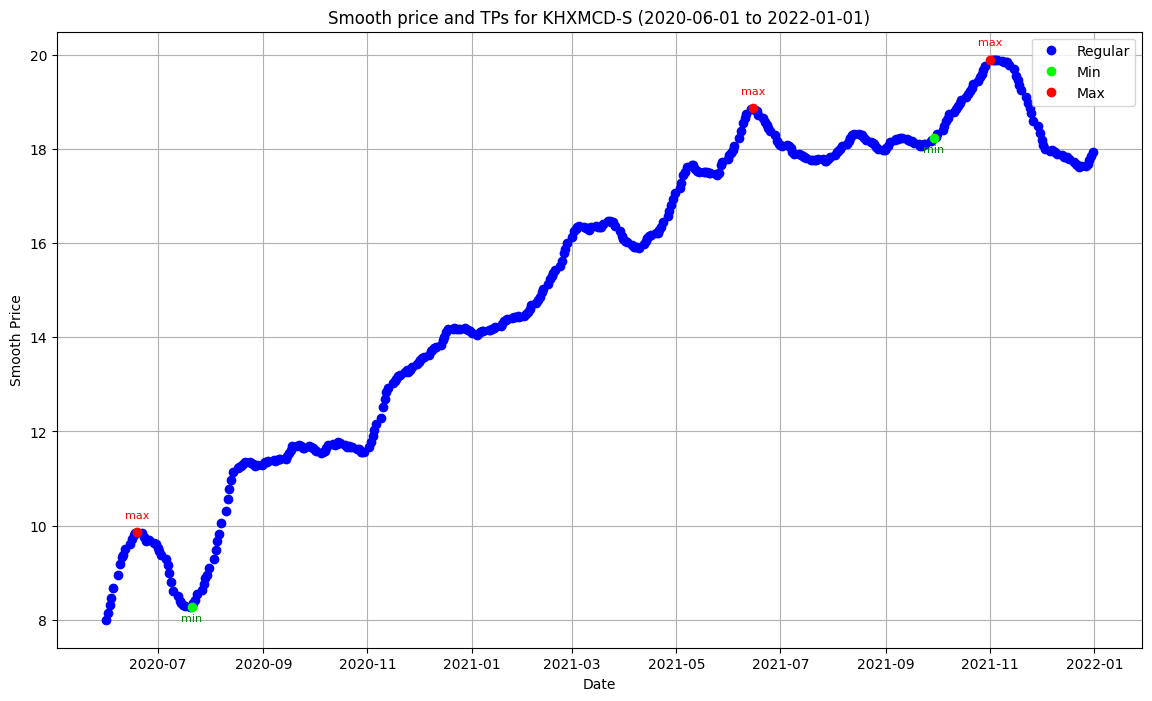

In [9]:
# ex-problem periods: 'B00CQC-S' 2003-06 to 2003-08, 'S84S9W-S' 2024-04 to 2024-05 - min and max are too close together
# - fixed by removing TPs according to: <=5% price change in <=1 month between (min, max) or (max, min) - leaves us with significant TPs
# - want only significant TPs
# plot_TPs_for_stock(adj_with_labels, 'F5YZB7-S', '2001-06-01', '2003-01-01') # takes 45s each to run
# plot_TPs_for_stock(adj_with_labels, 'HVQ6TN-S', '2007-06-01', '2009-01-01') # takes 45s each to run
# plot_TPs_for_stock(adj_with_labels, 'K7T5TF-S', '2012-06-01', '2014-01-01') # takes 45s each to run
# u.plot_TPs_for_stock(adj_with_labels, 'C0TNSZ-S', '2017-06-01', '2019-01-01') # takes 45s each to run
u.plot_TPs_for_stock(adj_with_labels, 'KHXMCD-S', '2020-06-01', '2022-01-01') # takes 45s each to run

# also tested for following periods:
# 'B00CQC-S' from '2003-01-01' to '2004-01-01', from '2007-01-01' to '2008-01-01', from '2020-01-01' to '2021-01-01'
# 'MS9FKZ-S' from '2004-01-01' to '2005-01-01', from '2011-01-01' to '2012-01-01', from '2022-01-01' to '2023-01-01'
# 'S84S9W-S' from '2018-06-18' - '2019-06-18',  from '2023-06-24' to '2024-06-24'

### Further Clean of Features Data

- 30% threshold of missing values above which a column should be dropped

In [33]:
# Drop all columns with < 30% filled values
funda_stock_subset, dropped_features, perc_missing, perc_missing_before = u.drop_na_features(funda_stock_subset, drop_threshold=0.3)
print(f'Av. NaN for dataset before reduction: {np.mean(perc_missing_before)}')
print(f'Av. NaN for reduced dataset: {np.mean(perc_missing)}')

Number of columns pre-drop: 595
Number of columns post-drop: 277
Av. NaN for dataset before reduction: 0.437487091606447
Av. NaN for reduced dataset: 0.07142882602109454


In [26]:
funda_stock_subset = funda_stock_subset.drop(*dropped_features) # ~270 left over

In [29]:
def attach_labels(fundamentals_data, price_data_with_labels):
    # Define a window specification to partition by 'fsym' and order by 'date'
    win = Window.partitionBy('fsym').orderBy('date')
    
    # Filter minmax_data for min and max labels only
    minmax_data = price_data_with_labels.filter((F.col("Label") == "min") | (F.col("Label") == "max"))
    
    # Add a new column for the date 4 weeks after each fundamental date
    fundamentals_with_end_date = fundamentals_data.withColumn("end_date", F.col("date") + F.expr("INTERVAL 28 DAYS"))
    
    # Join the minmax_data with fundamentals_with_end_date on fsym and where p_date is within the next 4 weeks
    joined_df = fundamentals_with_end_date.join(
        minmax_data,
        (fundamentals_with_end_date['fsym'] == minmax_data['fsym_id']) &
        (minmax_data['p_date'] > fundamentals_with_end_date['date']) &
        (minmax_data['p_date'] <= fundamentals_with_end_date['end_date']),
        how='left'
    )
    
    # Group by fsym and date to check for the presence of both min and max labels within the 28-day window
    label_summary = joined_df.groupBy("fsym", "date").agg(
        F.sum(F.when(F.col("Label") == "min", 1).otherwise(0)).alias("min_count"),
        F.sum(F.when(F.col("Label") == "max", 1).otherwise(0)).alias("max_count")
    )
    
    # Determine the label based on the presence of min and max within the window
    label_summary = label_summary.withColumn("label", 
        F.when((F.col("min_count") > 0) & (F.col("max_count") > 0), "both")
         .when((F.col("min_count") > 0) & (F.col("max_count") == 0), "min")
         .when((F.col("max_count") > 0) & (F.col("min_count") == 0), "max")
         .otherwise("none")
    )
    
    # Add the new 'label' column to the original fundamentals_data
    labeled_fundamentals_df = fundamentals_data.join(
        label_summary.select("fsym", "date", "label").distinct(),
        on=["fsym", "date"],
        how="left"
    )
    
    return labeled_fundamentals_df

In [3]:
funda_stock_subset = attach_labels(funda_stock_subset, adj_with_labels)

In [31]:
# Making sure no columns have nulls, if they do then fill with 0 (no diff to sector mkt cap category avg)
double_columns = [column for column, dtype in funda_stock_subset.dtypes if dtype == 'double']

# Fillna for all double columns with 0 - these are roughly 7% of each column
funda_stock_subset = funda_stock_subset.fillna(0, subset=double_columns)

In [31]:
# u.count_total_infinity_values(funda_stock_subset) - there were 0 for Finance
# Interpolate inf/-inf values for train and ffill in test
train_cutoff = '2020-01-01' # (train/validate up to 2020, test after)
feature_columns = [c for c in funda_stock_subset.columns if c not in ['date', 'fsym', 'label']]
funda_train, funda_test = u.interpolate_inf_columns(funda_stock_subset, feature_columns)

In [16]:
# for ease of successive runs of file
train_cutoff = '2018-01-01'
feature_columns = [c for c in funda_with_labels.columns if c not in ['date', 'fsym', 'label']]
funda_train = funda_stock_subset.filter(to_date(funda_stock_subset['date']) < train_cutoff)
funda_test = funda_stock_subset.filter(to_date(funda_stock_subset['date']) > train_cutoff)

In [10]:
# Drop static features below threshold variance: Drop if over 50% of the number of stocks record it as static
# 60-100 dropped for the finance sector
static_features = u.remove_static_features(funda_df, feature_columns, num_stocks = 10, var_threshold = 0.001)
print(f'Number of features dropped: {len(static_features)}')
funda_train = funda_train.drop(*static_features)
funda_test = funda_test.drop(*static_features)
funda_stock_subset = funda_stock_subset.drop(*static_features)
#print(static_features)

### Checks after interpolation and static feature removal

In [4]:
u.check_symbols_match(adj_with_labels, funda_stock_subset) 
u.count_total_infinity_values(funda_stock_subset) 
u.count_total_infinity_values(adj_with_labels)
# the 5 symbols match

In [75]:
from pyspark.sql.functions import min, max

# Find the earliest date
earliest_date = funda_stock_subset.select(min("date")).collect()[0][0]
print(f"Earliest Date: {earliest_date}")

# Find the latest date
latest_date = funda_stock_subset.select(max("date")).collect()[0][0]
print(f"Latest Date: {latest_date}")

Earliest Date: 2000-02-04
Latest Date: 2024-05-03


### Join features to returns

In [18]:
adj = adj_with_labels.select('fsym_id', 'p_date', 'adj_price')
del adj_with_labels
mthly_returns = u.create_returns_df(adj, lag_=20, pandas=False, shift=True)
print("creating returns df done")
#takes 12mins in total to run all 3 below
rf_df = u.concatenate_features(funda_stock_subset, mthly_returns, train_end='2024-07-01', lag=20)
print("combining entire datasets done")
rf_train = u.concatenate_features(funda_train, mthly_returns, train_end=train_cutoff, lag=20) # note the input features have the TP labels
# combining returns and fundamentals + TP labels
print("combining train datasets done")
rf_test = u.concatenate_features(funda_test, mthly_returns, train_end='2024-07-01', lag=20)
print("combining test datasets done")

creating returns df done
Number of columns in train set: 492
combining entire datasets done
Number of columns in train set: 492
combining train datasets done
Number of columns in train set: 492
combining test datasets done


In [5]:
rf_features, important_features_df = u.rf_feature_selection(rf_train, num_features=int(len(rf_train.columns)/10), plot=True)
print(rf_features)
rf_features = ['fsym', 'date', 'label', 'returns'] + rf_features
rf_train = rf_train.select(*rf_features)
rf_test = rf_test.select(*rf_features)
rf_df = rf_df.select(*rf_features)

In [6]:
important_features_df.head(10)

#### Correlations
##### 1. plot heatmap before
##### 2. identify features with correlation > 0.7, remove feature with lower importance in each pair, reflect this in train and test sets
##### 3. plot heatmap after

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import functions as F

def remove_high_corr_features(features_train, important_features_df, corr_threshold=0.7, plot_before=True, plot_after=True, save_before=True, save_after=True):
    
    features_train = features_train.repartition(20, 'fsym', 'date')
    features_train = features_train.na.fill(0)
    
    #win = Window.partitionBy('fsym').orderBy('date')
    # Extract a list of unique stock IDs
    unique_stock_ids = [row['fsym'] for row in features_train.select('fsym').distinct().collect()]
    
    # Filter features_train for these sampled stock IDs
    sampled_stocks = features_train.filter(F.col('fsym').isin(unique_stock_ids))
    
    sampled_stocks = sampled_stocks.repartition(20, 'fsym', 'date')
    
    features_train_before_list = [col for col in sampled_stocks.columns if col not in ['fsym', 'date', 'label', 'returns']]
    
    # Calculate the avg correlation matrix for each sampled stock and store them - need to do this afterwards too so create func for it
    def average_corr_matrix_pd(sampled_stocks_df, sampled_stock_ids, feature_columns):
        corr_matrices = {}
        for stock_id in sampled_stock_ids:
            stock_data = sampled_stocks_df.filter(F.col('fsym') == stock_id).select(feature_columns)
            stock_data = stock_data.repartition(20, 'fsym', 'date')
            stock_data_pd = stock_data.toPandas()

            # Calculate correlation matrix using pandas
            print(f"Calculating correlation matrix for {stock_id}...")
            corr_matrix = stock_data_pd.corr()

            # Store the correlation matrix in the dictionary
            corr_matrices[stock_id] = corr_matrix
            print(f"stored matrix for {stock_id}")

        # Convert correlation matrices to NumPy arrays for averaging
        print("Converting matrices list to NumPy...")
        corr_matrices_np = [corr_matrices[stock_id].to_numpy() for stock_id in sampled_stock_ids]

        # Calculate the element-wise average correlation matrix
        print("Averaging sample matrices...")
        average_corr_matrix_np = np.mean(corr_matrices_np, axis=0)

        # Convert the combined correlation matrix back to a DataFrame
        print("Converting average matrix to df...")
        average_corr_matrix = pd.DataFrame(average_corr_matrix_np, index=feature_columns, columns=feature_columns)
        return average_corr_matrix
    
    avg_corr_matrix_before = average_corr_matrix_pd(sampled_stocks, unique_stock_ids, features_train_before_list)

    # Plot the average correlation matrix before removing correlated features
    if plot_before:
        print("plotting...")
        mask = np.triu(np.ones_like(avg_corr_matrix_before, dtype=bool))
        plt.figure(figsize=(20, 15))
        sns.heatmap(np.round(avg_corr_matrix_before, 2), mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
        plt.title("Before correlated feature removal")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        if save_before:
            plt.savefig('Corr_matrix_before_selection.png', dpi=72)
        plt.close()
    
    # Find pairs of features with correlation above the threshold
    correlated_pairs = []
    for i in range(len(avg_corr_matrix_before.columns)):
        for j in range(i):
            if np.abs(avg_corr_matrix_before.iloc[i, j]) > corr_threshold:
                colname_i = avg_corr_matrix_before.columns[i]
                colname_j = avg_corr_matrix_before.columns[j]
                correlated_pairs.append((colname_i, colname_j))

    # Drop the feature with lower importance from each pair
    features_to_drop = set()
    for pair in correlated_pairs:
        feature1, feature2 = pair
        importance1 = important_features_df.loc[important_features_df['Feature'] == feature1, 'Importance'].values[0]
        importance2 = important_features_df.loc[important_features_df['Feature'] == feature2, 'Importance'].values[0]
        
        if importance1 < importance2:
            features_to_drop.add(feature1)
        else:
            features_to_drop.add(feature2)
    
    # Remove the identified features from funda_train and funda_test
    features_train_after = features_train.drop(*features_to_drop)
    
    # Update the list of features after dropping
    features_train_after_list = [col for col in features_train_after.columns if col not in ['fsym', 'date', 'label', 'returns']]
    
    avg_corr_matrix_after = average_corr_matrix_pd(sampled_stocks, unique_stock_ids, features_train_after_list)
    
    # Plot the average correlation matrix before removing correlated features
    if plot_after:
        print("plotting...")
        mask = np.triu(np.ones_like(avg_corr_matrix_after, dtype=bool))
        plt.figure(figsize=(20, 15))
        sns.heatmap(np.round(avg_corr_matrix_after, 2), mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
        plt.title("After correlated feature removal")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        if save_after:
            plt.savefig('Corr_matrix_after_selection.png', dpi=72)
        plt.close()
    
    return features_to_drop, features_train_after

In [7]:
# Remove highly correlated features, plot corr heatmap
corr_dropped_features, rf_train = remove_high_corr_features(rf_train, important_features_df)
#print(corr_dropped_features)
rf_test = rf_test.drop(*corr_dropped_features) # already done for train set in function
rf_df = rf_df.drop(*corr_dropped_features)

In [8]:
# Compute mutual information between each feature and the target
no_mi_features = u.mutual_info_selection(rf_train, plot=True)
#print(no_mi_features)
rf_train = rf_train.drop(*no_mi_features)
rf_test = rf_test.drop(*no_mi_features)
rf_df = rf_df.drop(*no_mi_features)

In [24]:
print(len(rf_train.columns), len(rf_test.columns))

38 38


In [27]:
# Specify the path where you want to save the DataFrame
output_path = "/path/to/ATPSiftingAnalyticsRepo/rf_df.csv"

# Save the DataFrame as CSV files in the specified directory
rf_df.write.csv(output_path, header=True)

In [29]:
output_path_adj = "/path/to/ATPSiftingAnalyticsRepo/adj.csv"
adj.write.csv(output_path_adj, header=True)

In [30]:
output_path_train = "/path/to/ATPSiftingAnalyticsRepo/rf_train.csv"
rf_train.write.csv(output_path_train, header = True)
output_path_test = "/path/to/ATPSiftingAnalyticsRepo/rf_test.csv"
rf_test.write.csv(output_path_test, header = True)

In [9]:
# To find out more about PySpark, please refer to: https://spark.apache.org/docs/latest/api/python/getting_started/index.html
spark.stop()